In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
import astropy.units as u
import sys 
import os
sys.path.append("../src")
from regression import FrequentistRegression
# from scipy.optimize import curve_fit
params = {
         'axes.labelsize': 20,
         'axes.titlesize': 20,
         'ytick.labelsize' :20,
         'xtick.labelsize' :20,
         'legend.fontsize': 15,
         'xtick.major.size': 5,
         'xtick.minor.size': 4,
         'xtick.major.width': 3,
         'xtick.minor.width': 2,
         'ytick.major.size': 5,
         'ytick.minor.size': 4,
         'ytick.major.width': 3,
         'ytick.minor.width': 2,
         'ytick.color': "k",
         'xtick.color': "k",
         'axes.labelcolor': "k",
         'ytick.labelcolor' : "k",
         'xtick.labelcolor' : "k",
         'font.size': 15
         }
plt.rcParams.update(params)
plt.style.use('science')

figure_folder = 'C://Users//noedi//Desktop//lab_optique//data//optique_non_lineaire'

## Théorie: 

Un laser utilise le principe d'inversion de population pour produire un faisceau cohérent de photons (une seule longueur d'onde, phase uniforme en temps et en espace). 

On veut faire différentes mesures spécifiques dans cette expériences: 
1) La puissance du laser en fonction du courant $I$ dans la diode
2) Déterminer la polarisation de l'émission laser
3) Ajouter cristal KTP et une lame demi-onde pour obtenir une émission pour la deuxième harmonique (doublage de fréquence) en fonction de l'angle de la lame demi-onde $\theta$ et de l'orientation du cristal (prendre des mesures pour plusieurs angles et orientations)
4) Déterminez (ou mesurer ?) l'intensité à 532 nm en fonction de l'orientation du cristal et de la lame demi-onde (mesurer pour différentes orientations et angles)
5) 
6) 
7) Expérience additionnelle: Polarisation après l'ajout du cristal ?

### Questions: 
Are we supposed to measure the polarization ? How ? 



## Semaine 1: 
Les différentes expériences de cette semaine incluent: 
1) Mesures de la loi de Malus
2) Mesures du spectre $I$ vs $\lambda$ du laser autour de 1064 nm (avec un courant dans la pompe $I_p$ constant)
3) Mesures du rapport $\frac{I_{max}(1064 \text{nm})}{I_{max}(\text{808 nm})}$ en fonction du courant dans la pompe. 


#### Loi de Malus. 

La loi de Malus relie l'intensité d'une onde polarisée linéairement d'intensité $I_0 = \sqrt{E_0}$ à l'intensité $I$ de l'onde après son passage dans un polariseur linéaire parfait orienté selon un angle $\theta - \phi$ par rapport au plan de propagation de l'onde. Mathématiquement, on a 
$$
I(\theta) = I_0 \cos^2(\theta - \phi) \, .
$$
Durant l'expérience, on mesurait seulement $\theta$, l'angle de polarisation du polariseur par rapport à la verticale. Cependant, la loi de Malus s'applique pour **l'angle de polarisation entre le polariseur et la direction de polarisation du laser** et on doit introduire le déphasage $\phi$. Il nous faut donc ajuster deux paramètres, $I_0$ et $\phi$. 

Parlons d'incertitudes avant de commencer le code. On utilise la plus demie-mesure de la plus petite graduation de notre instrument de mesure pour l'angle, donc $\sigma_\theta \sim 2$ degrés. Pour I, on prend une vingtaine de mesures au même angle en réinitialisant le set up expérimental à chaque fois et on mesure l'écart type de cet ensemble de mesures. 

Petit calcul pour "rendre la loi de Malus linéaire": 
$$
\begin{align}
\cos^2(\theta - \phi)&=\frac{1 + \cos\left(2(\theta - \phi)\right)}{2}
\\
&=\frac{1}{2} + \frac{1}{2}\cos(2(\theta - \phi))
\\
&=\frac{1}{2} + \frac{1}{2}\left[\cos(2\theta)\cos(2\phi) + \sin(2 \theta)\sin(2 \phi) \right]
\\
&= \frac{1}{2} + \beta_1\cos(2\theta) +\beta_2 \sin(2 \theta) 
\end{align}
$$
On peut donc réécrire la loi de Malus de manière linéaire comme 
$$
I(\theta) = \beta_0 + \beta_1 \cos(2 \theta) + \beta_2 \sin(2\theta)
$$
où les $\beta_i$ sont les paramètres à ajuster avec 
$$
\begin{align}
\beta_0 = \frac{I_0}{2} &\rightarrow I_0 = 2 \beta_0
\\
\beta_1 = \frac{I_0}{2} \cos(2\phi) &\rightarrow \phi = \frac{1}{2}\arccos(\beta_1/\beta_0)
\\
\beta_2 = \frac{I_0}{2}\sin(2\phi) &\rightarrow \phi = -\frac{1}{2}\arcsin(\beta_2/\beta_0)
\\
\frac{\beta_2}{\beta_1}= \tan(2 \phi) &\rightarrow \phi = \frac{1}{2}\arctan(\beta_2/\beta_1)
\end{align}
$$

À l'issue de la régression linéaire, on a des incertitudes sur les paramètres ajustées $\beta_i$. On utilise donc la formule de propagation des incertitudes pour retrouver les incertitudes sur les variables physiques $I_0$ et $\phi$.
$$
\begin{align}
I_0 &= 2 \beta_0 \\
\sigma_{I_0} &=|\frac{\partial I_0}{\partial \beta_0}\sigma_{\beta_0}|=2 \sigma_{\beta_0}\\
\phi &= \frac{1}{2} \arctan\left( \frac{\beta_2}{\beta_1}\right)
\\
\frac{\partial \phi}{\partial \beta_2} &= \frac{\beta_1}{2(\beta_1^2 + \beta_2^2)} 
\\
\frac{\partial \phi}{\partial \beta_1} &= -\frac{\beta_2}{2(\beta_1^2 + \beta_2^2)} 
\\
\sigma_\phi &= \sqrt{\left( \frac{\partial \phi}{\partial \beta_1}\right)^2\sigma_{\beta_1}^2 + \left( \frac{\partial \phi}{\partial \beta_2}\right)^2\sigma_{\beta_2}^2} 
\\
&= \sqrt{\left(\frac{\beta_1}{2(\beta_1^2 + \beta_2^2)} \right)^2 \sigma_{\beta_1}^2 + \left(\frac{\beta_2}{2(\beta_1^2 + \beta_2^2)} \right)^2 \sigma_{\beta_2}^2}
\\
&= \frac{1}{2(\beta_1^2 + \beta_2^2)}\sqrt{\beta_1^2\sigma_{\beta_1}^2 + \beta_2 \sigma_{\beta_2}^2}
\end{align}
$$

Dernière équation ici. On va également avoir une incertitude sur l'intensité prédite par la loi de Malus en propageant les incertitudes une dernière fois. 
$$
\begin{align}
\sigma_{I} &= \sqrt{\left( \frac{\partial I}{\partial I_0}\right)^2\sigma_{I_0}^2 + 
\left( \frac{\partial I}{\partial \theta}\right)^2\sigma_{\theta}^2
+
\left( \frac{\partial I}{\partial \phi}\right)^2\sigma_{\phi}^2}
\\
&= \sqrt{\cos^2(\theta-\phi)\sigma_{I_0}^2  + 4 I_0^2\sin^2(\theta-\phi)\cos^2(\theta-\phi)\sigma_{\phi}^2+4 I_0^2\sin^2(\theta-\phi)\cos^2(\theta-\phi)\sigma_{\theta}^2}
\end{align}
$$

Note: De manière équivalente, on peut faire passer les valeurs $(I_{0}, \theta, \phi)$ perturbées par les déviations standards $(\sigma_{I_{0}},\sigma_{\theta}, \sigma_{\phi})$ puis les faire passer dans la loi de Malus afin de propager les incertitudes. Cette méthode implique moins de maths (mais la précédente constitue une belle dérivation!).

In [2]:
def malus_law(theta, I0, phi):
    return I0 * np.cos(theta - phi) ** 2

def fit_params_to_phys_params(param1, param2, param3): 
    return np.array([2 * param1, 0.5 * np.arctan(param3 / param2)])

def std_params_to_std_physical(params, stds): 
    """
    Must take as input the combination (value, std)

    Args:
        pair1 (Tuple): _description_
        pair2 (Tuple): _description_
        pair3 (Tuple): _description_
    """
    sigma_intensity_fitted = 2 * stds[0]

    beta1, beta2 = params[1:]
    sigma_beta1 = stds[1]
    sigma_beta2 = stds[2]
    sigma_phi_fitted = 1 / (beta1 ** 2 + beta2 ** 2) * np.sqrt(beta1 ** 2 * sigma_beta1 ** 2 + beta2 ** 2 * sigma_beta2 ** 2)
    return np.array([sigma_intensity_fitted, sigma_phi_fitted])

def std_malus(theta, phys_fitted, phys_std, std_theta):
    I0, phi = phys_fitted
    std_intensity, std_phi = phys_std
    return np.sqrt(np.cos(theta - phi) ** 2 * std_intensity ** 2  + (2 * I0 * np.sin(theta - phi) * np.cos(theta - phi)) ** 2 * (std_phi ** 2 + std_theta ** 2))

In [28]:
# Importation des valeurs expérimentales mesurées 
theta = np.arange(20, 361, 20) * u.degree.to(u.radian)  # rad
sigma_theta = 2 * u.degree.to(u.radian) # rad
intensity_20 = np.array([0.007,  0.0073, 0.0072,0.00702, 0.00713, 0.00612, 0.00625, 0.00618, 0.0064]) # series of measurements at theta=20 radians
intensity = np.array([intensity_20.mean(), 0.01000, 0.00842, 0.00527, 0.00186, 0.00023, 0.00049, 0.00275, 0.0053, 0.00835, 0.00920, 0.00770, 0.00520, 0.00200, 0.0002, 0.00049, 0.0026, 0.00590]) # mA
sigma_intensity = intensity_20.std(ddof = 1)

# Régression linéaire (voir code dans src/regression.py)
Regression = FrequentistRegression(
    degree = 1,
    sigma_noise = sigma_intensity
)

# Créer la 'design matrix' de régression
Regression.design_matrix = np.column_stack([np.ones_like(theta),  np.cos(2 * theta), np.sin(2 * theta)])

# Calcul des paramètres beta_i optimaux
params_fitted, std_fitted = Regression.fit(
    obs = intensity, 
    x = None, 
    ridge_reg = 1e-9, 
    fit_intercept = True
)

# Conversion des paramètres de régression ajustées aux paramèteres physiques d'intérêt (ici, l'intensité initiale du faisceau et le déphasage)
phys_fitted = fit_params_to_phys_params(*params_fitted) 
phys_std = std_params_to_std_physical(params = params_fitted, stds = std_fitted)# incertitude sur paramètre physique
intensity_fitted, phi_fitted = phys_fitted
intensity_pred = malus_law(theta, *phys_fitted) # intensity predicted by adjusting our physical model on data 
norm_residuals =  (intensity - intensity_pred) / sigma_intensity 
chi2 = Regression.compute_chi2(obs = intensity)

print(f"Intensité initiale du laser: {phys_fitted[0] * 1e3:.2f} +/- {phys_std[0]* 1e3:.2f} micro-amperes")
print(f"Déphasage: {phys_fitted[1] *u.radian.to(u.degree):.0f} +/- {phys_std[1]*u.radian.to(u.degree):.0f} degrees")
print(chi2)

Intensité initiale du laser: 9.19 +/- 0.23 micro-amperes
Déphasage: 39 +/- 2 degrees
1.022764447656902


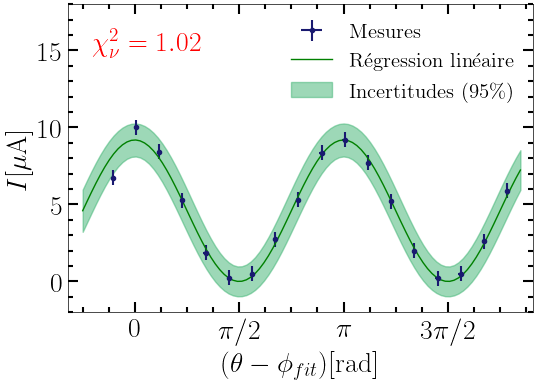

In [31]:
from matplotlib.ticker import MultipleLocator
# Première figure: Intensité versus angle 
fig, axs = plt.subplots(1, 1, figsize = (6, 4))
ax = axs

# Afficher mesures avec erreurs
x = theta - phi_fitted # tableau de valeurs axe des x
ax.errorbar(x = x, 
            y = intensity * 1e3, 
            xerr = sigma_theta, 
            yerr = sigma_intensity * 1e3, 
            fmt = '.', 
            elinewidth=1.5, 
            label = 'Mesures', 
            color = 'midnightblue'
            )

# Afficher prédiction du model 
x_range = np.array([-np.pi / 4, 2 * np.pi])
x_fit =  np.linspace(x_range.min(), x_range.max()-phi_fitted + 0.2, 100)
intensity_fitted = malus_law(x_fit + phi_fitted, *phys_fitted)
ax.plot(x_fit, intensity_fitted * 1e3, "green", label = 'Régression linéaire')

# Afficher incertitudes sur la régression linéaire
# phys_min = phys_fitted - 1 * phys_std
# phys_max = phys_fitted + 1 * phys_std
# intensity_min = malus_law(x_fit + phi_fitted, *phys_min)
# intensity_max = malus_law(x_fit + phi_fitted, *phys_max)
std_intensity = np.sqrt(std_malus(theta = x_fit + phi_fitted, phys_fitted = phys_fitted, phys_std = phys_std, std_theta=sigma_theta) **2 + sigma_intensity ** 2)
k = 2
ax.fill_between(
    x = x_fit, 
    y1 = (intensity_fitted - k * std_intensity) * 1e3, 
    y2 = (intensity_fitted + k * std_intensity) * 1e3,
    color = 'mediumseagreen', 
    alpha = 0.5, 
    label = r'Incertitudes ($95\%$)'
    )

# Rendre la figure plus jolie :) 
ax.set(xlabel = r"$(\theta-\phi_{fit})$[rad]", ylabel = r"$I$[$\mu$A]", xlim = [-1, 6.], ylim = [-2, 18])
x_ticks = np.arange(0, 5, np.pi/2)
x_tick_labels = [r"$0$", r"$\pi/2$", r"$\pi$", r"$3\pi/2$"]
ax.xaxis.set_ticks(x_ticks)
ax.xaxis.set_ticklabels(x_tick_labels)

ax.tick_params(which = 'major', axis = 'both', length = 7, width = 1.5)
ax.tick_params(which = 'minor', axis = 'both', length = 3.5, width = 1.5)
ax.annotate(r"$\chi^2_{\nu} = %.2f$"%chi2, xy = (0.05, 0.85), xycoords = 'axes fraction', color = 'r', fontsize = 20)
handles, labels = plt.gca().get_legend_handles_labels()
order = [2,0,1]
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
plt.savefig(os.path.join(figure_folder, 'figure_malus.pdf'), bbox_inches = 'tight')
# maj_ticks = 

(array([ 1.,  0.,  4., 11.,  2.]),
 array([-3.07211272, -2.12111694, -1.17012116, -0.21912538,  0.73187039,
         1.68286617]),
 <BarContainer object of 5 artists>)

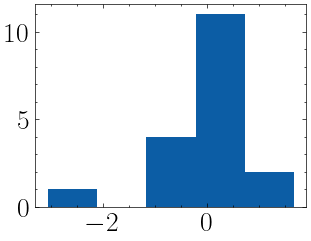

In [37]:
plt.hist(norm_residuals, bins = 5)

### Calcul de la largeur spectrale du pic d'émission du laser 
Commençons par importer les données et puis par estimer l'incertitude sur le 'counts' mesuré par le spectromètre

In [38]:
def import_data(filename):
    wavelength = []
    intensity = []
    with open(filename, "r") as f: 
        lines = f.readlines()
        lines = lines[17:-1]
        for line in lines:
            line = line.strip()
            line = line.split("\t")
            wavelength.append(float(line[0].replace(",", "."))) # counts 
            intensity.append(float(line[1].replace(",", "."))) # nanometers 
    return np.array(wavelength), np.array(intensity)

def get_window(wavelength, intensity, wavelength_center = 1064, extent = 50):
    """
    Get a slice of the wavelength data and the intensity data around a specific wavelength
    """
    idx_center = np.argmin(abs(wavelength - wavelength_center))
    D, U = idx_center - extent, idx_center + extent
    return wavelength[D:U], intensity[D:U]


In [39]:
from glob import glob
from tqdm import tqdm 
pattern = "450_std*.txt"
std_files = glob(os.path.join(figure_folder, pattern))

std_file = std_files[0]
wavelength = []
intensity = []

low_center = 808 #nm
high_center = 1064 #nm
multiple_intensity_peaks = np.empty(shape = (len(std_files), 2))

for i, std_file in tqdm(enumerate(std_files)):
    wavelength, intensity = import_data(filename = std_file)

    wavelength_low, intensity_low = get_window(wavelength = wavelength, 
                                            intensity = intensity, 
                                            wavelength_center = low_center, 
                                            extent = 500) 

    wavelength_high, intensity_high = get_window(wavelength = wavelength, 
                                            intensity = intensity, 
                                            wavelength_center = high_center, 
                                            extent = 500) 
    multiple_intensity_peaks[i] = np.array([intensity_low.max(), intensity_high.max()])


10it [00:00, 368.77it/s]


In [40]:
sigma_wavelength = 10 # nm (donnée par Arthur)
sigma_intensity = multiple_intensity_peaks.std(axis = 0, ddof = 1).max() # 

Le bruit de l'instrument semble varier avec l'intensité (ou peut-être la longueur d'onde?)... Puisque nous n'avons pas accès à la fonction de réponse du spectromètre selon la longueur d'onde, faisons pour l'instant l'hypothèse d'un bruit constant.

On peut maintenant importer les données pour le fit de la Gaussienne.

1411.8454358552633


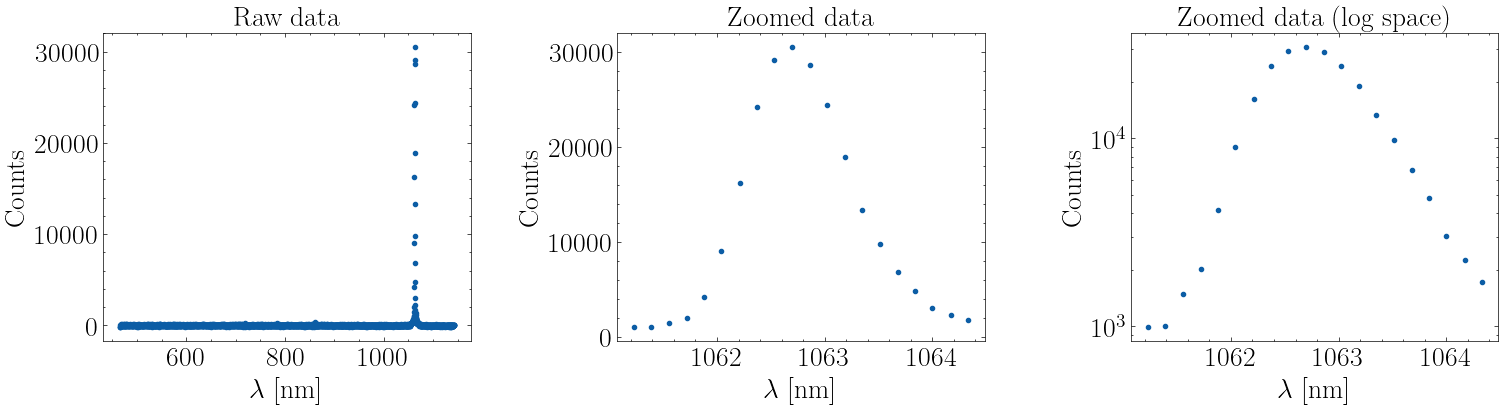

In [41]:
filename = os.path.join(figure_folder, "spectral_width_low_counts.txt")

wavelength, intensity = import_data(filename = filename)
print(intensity.mean())
high_center = 1062.9
wavelength_window, intensity_window = get_window(wavelength = wavelength, 
                                            intensity = intensity, 
                                            wavelength_center = high_center, 
                                            extent = 10) 

# Calcul d'ordonnée à l'origine à retirer (bruit ambiant)
wavelength_window_noise, intensity_window_noise = get_window(wavelength = wavelength, 
                                            intensity = intensity, 
                                            wavelength_center = 700, 
                                            extent = 1000)
offset = intensity_window_noise.mean()
std = intensity_window_noise.std() 

nrows, ncols = 1, 3
fig, axs = plt.subplots(nrows, ncols, figsize = (6 * ncols, 4 * nrows))

ax = axs[0]
ax.plot(wavelength, intensity-offset, ".")
ax.set_title("Raw data")


ax = axs[1]
ax.plot(wavelength_window, intensity_window-offset, ".")
ax.set_title("Zoomed data")


ax = axs[2]
ax.plot(wavelength_window, intensity_window-offset, ".")
ax.set_title("Zoomed data (log space)")
ax.set_yscale("log")

for ax in axs: 
    ax.set(xlabel = r"$\lambda$ [nm]", ylabel= r"Counts")
plt.subplots_adjust(wspace=0.4)

# Selection d'une portion des données pour la suite
wavelength = wavelength_window
intensity = intensity_window - offset

In [10]:
std

np.float64(55.72405565845957)

In [11]:
offset

np.float64(1344.56223)

On veut maintenant faire une régression linéaire sur une Gaussienne. L'astuce ici est de faire la régression dans l'espace logarithmique. L'intensité (en termes de comptes) est ici définie comme 
$$
\begin{align}
I(\lambda) = I_{0} \exp\left(-\frac{(\lambda-\lambda_0)^2}{2w^2}\right)
\end{align}
$$
où $\lambda_{0}$ est la moyenne de la Gaussienne (là où le pic d'émission du laser est censé se situer)

On peut maintenant appliquer le log
$$
\begin{align}
\ln I (\lambda)&= -\frac{(\lambda - \lambda_0)^2}{2w^2} + \ln(I_0)
\\
&= -\frac{1}{2w^2} \left(\lambda^2 - 2 \lambda \lambda_{0} +\lambda_{0}^2\right) + \ln(I_0)
\\
&= \underbrace{-\frac{1}{2w^2}}_{\beta_0} \lambda^2 + \underbrace{\frac{\lambda_0}{w^2}}_{\beta_1} \lambda - \underbrace{\frac{\lambda_{0}^{2}}{2w^2} + \ln(I_0)}_{\beta_2}
\\
&= \beta_0 \lambda^2 + \beta_1 \lambda + \beta_2
\end{align}
$$

On isole maintenant les variables $\lambda_0, w, I_0$ à partir des paramètres de la régression linéaire
$$
\begin{align}
w^2 &= -\frac{1}{2 \beta_0}
\\
\lambda_0 &= w^2 \beta_1 =-\frac{\beta_1}{2 \beta_0}
\\
\beta_2 &= -\frac{\lambda_0^2}{2w^2} + \ln(I_0) \Longrightarrow \lambda_0^2=\frac{\beta_1^2}{4\beta_0^2} \Longrightarrow \frac{\lambda_0^2}{2w^2}=\frac{1}{w^2}\frac{\beta_1^2}{8\beta_0^2} = \frac{\beta_1^2}{2}
\\
I_0 &= e^{\beta_2+\frac{\beta_1^2}{2}} = \exp\left( \beta_2 + \frac{\beta_1^2}{2}\right)
\end{align}
$$

Finalement, il faut propager les incertitudes en espace logarithmique: 
$$
\sigma_{\ln(I)} = \Biggr \lvert \frac{\partial \ln(I)}{\partial I} \Biggr \rvert  \sigma_I= \frac{\sigma_{I}}{I} \, .
$$

Ici, on semble un peu embêter aux premiers abords afin d'inclure l'incertitude sur $\ln(I)$; l'incertitude dépend de l'intensité elle-même et n'est pas constante ! La solution (fréquentiste) est de minimiser le "weighted chi squared", ou le poids est défini comme $w(I)=\frac{1}{\sigma^{2}_{\ln(I)}}$. Une version de la régression pondérée (qui a une solution analytique) est implémentée dans l'objet `FrequentistRegression` avec la méthode `wfit`. 

In [42]:
def gaussian_profile(wavelength, I0 = 10, wavelength_center = 1064, width = 2): 
    I = I0 * np.exp( -(wavelength - wavelength_center) ** 2 / (2 * width) ** 2)
    return I

def fitted_params_to_phys_params(fitted_params):
    beta2, beta1, beta0 = fitted_params
    w2 = -1 / (2 * beta0)
    lambda_0 = - beta1 / (2 * beta0)
    I0 = np.exp(beta2 + lambda_0 **2/ (2 * w2))
    print(beta2)
    return np.array([I0, lambda_0, w2])  

def compute_fwhm(sigma): 
    """
    Compute the FWHM of a Gaussian from its standard deviation
    """
    return 2 * np.sqrt(2 * np.log(2)) * sigma

In [43]:
Regression_width = FrequentistRegression(
    degree = 2,
    sigma_noise = sigma_intensity /intensity,
) 

params_fitted, std_fitted = Regression_width.wfit(
    obs = np.log(intensity), 
    x = wavelength, 
    ridge_reg = 0, 
    fit_intercept = True
)

chi2 = Regression_width.compute_chi2(
    obs = np.log(intensity)
)
print( "chi", chi2)
phys_fitted = fitted_params_to_phys_params(params_fitted)
pred_intensity_log = Regression_width.forward_model()
print(phys_fitted)

chi 1.0773725881825154
-2025327.4458821355
[2.99295016e+04 1.06274858e+03 2.78826219e-01]


Parfait, nous avons nos valeurs physiques optimales. Maintenant, propageons les incertitudes sur notre profil Gaussien pour obtenir une incertitude sur les prédictions de notre modèle. 
$$
\begin{align}
\sigma_{I_{m}}^2 = \sigma_{I}^2 + \left(\frac{\partial I}{\partial I_{0}}\right)^2 \sigma_{I_{0}}^2+\left(\frac{\partial I}{\partial \lambda_{0}}\right)^2 \sigma_{\lambda_{0}}^2
+ 
\left(\frac{\partial I}{\partial \lambda}\right)^2 \sigma_{\lambda}^2
+ 
\left(\frac{\partial I}{\partial w}\right)^2 \sigma_{w}^2
\end{align}
$$

... Ça fait beaucoup.
Allons-y: 
$$
\begin{align}
\frac{\partial I}{\partial I_{0}} &= \exp\left(-\frac{(\lambda-\lambda_0)^2}{2w^2}\right)
\\
\frac{\partial I}{\partial \lambda} &= \frac{I_{0}}{w^2}(\lambda - \lambda_0)\exp\left(-\frac{(\lambda-\lambda_0)^2}{2w^2}\right)
\\
\frac{\partial I}{\partial \lambda_{0}} &= \frac{I_{0}}{w^2}(\lambda - \lambda_0)\exp\left(-\frac{(\lambda-\lambda_0)^2}{2w^2}\right)
\\
\frac{\partial I}{\partial w^2} &= \frac{I_{0}}{2w^4}(\lambda - \lambda_0)^2\exp\left(-\frac{(\lambda-\lambda_0)^2}{2w^2}\right)
\end{align}
$$

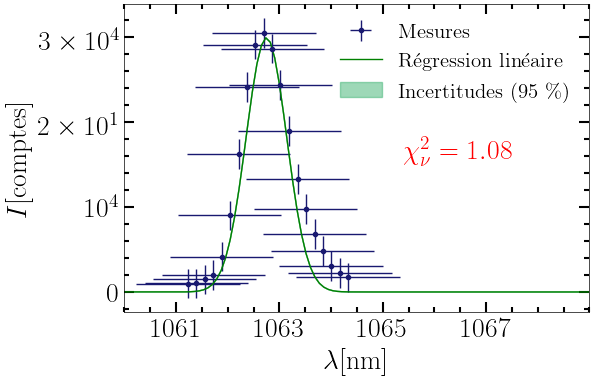

In [81]:
wavelength_fit = np.linspace(wavelength.min()-20, wavelength.max()+20, 500)


fig, axs = plt.subplots(1, 1, figsize = (6, 4))
ax = axs
ax.errorbar(x = wavelength, y = intensity, fmt = ".", xerr=sigma_wavelength / 10, yerr=sigma_intensity, label = "Mesures", color = "midnightblue")
intensity_prediction = gaussian_profile(wavelength_fit, *phys_fitted)
ax.plot(wavelength_fit, intensity_prediction, label = "Régression linéaire", color = "green")
ax.fill_between(wavelength_fit, intensity_prediction, intensity_prediction, label = "Incertitudes (95 \%)", color = "mediumseagreen", alpha = 0.5)


x_ticks = np.arange(1061, 1068, 2, dtype=np.int16)
x_tick_labels = x_ticks
y_ticks = np.arange(0, 30001, 10000)
y_tick_labels = [r"$0$", r"$10^4$", r"$2\times 10^1$", r"$3 \times 10^4$"]
ax.xaxis.set_ticks(x_ticks)
ax.xaxis.set_ticklabels(x_tick_labels)
ax.yaxis.set_ticks(y_ticks)
ax.yaxis.set_ticklabels(y_tick_labels)
ax.tick_params(which = 'major', axis = 'both', length = 7, width = 1.5)
ax.tick_params(which = 'minor', axis = 'both', length = 3.5, width = 1.5)
ax.annotate(r"$\chi^2_{\nu} = %.2f$"%chi2, xy = (0.6, 0.5), xycoords = 'axes fraction', color = 'r', fontsize = 20)
ax.set(xlabel = r"$\lambda$[nm]", ylabel = r"$I$[comptes]", xlim = (1060, 1069))
handles, labels = plt.gca().get_legend_handles_labels()
order = [2,0,1]

plt.savefig(os.path.join(figure_folder, 'figure_width.pdf'), bbox_inches = 'tight')
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc = "upper right")

In [260]:
sigma_intensity

np.float64(1739.620641975651)

In [197]:
params_fitted

array([-2.38813712e+04,  4.49330618e+01, -2.11282136e-02])

In [188]:
phys_fitted

array([ 1.00040762e+00,  9.40755484e-04, -2.09368213e-05])

In [182]:
pred_intensity

array([7.05400573, 7.10743488, 7.15660557, 7.2046945 , 7.25460369,
       7.30046147, 7.34800008, 7.39162673, 7.43417161, 7.47819025,
       7.518504  , 7.56015205, 7.59823466, 7.6352355 , 7.6733636 ,
       7.7081333 , 7.74182123, 7.77642937, 7.80788617, 7.84012372,
       7.86934938, 7.89749327, 7.92621086, 7.95212361, 7.9769546 ,
       8.00215223, 8.02475208, 8.04757913, 8.06794784, 8.08723478,
       8.10654187, 8.12359768, 8.13957172, 8.15535884, 8.16910175,
       8.18176288, 8.19403005, 8.20446005, 8.21380828, 8.22255548,
       8.22967258, 8.23570791, 8.24093515, 8.24473934, 8.24746177,
       8.24916905, 8.24966034, 8.24906986, 8.24725718, 8.24443557,
       8.24053218, 8.23519955, 8.22906503, 8.22184874, 8.21299614,
       8.20354872, 8.19301953, 8.18064697, 8.16788664, 8.15404455,
       8.13815203, 8.1220788 , 8.1049238 , 8.08668704, 8.06612519,
       8.04565728, 8.02410762, 8.0000258 , 7.976245  , 7.95138243,
       7.92378066, 7.89668695, 7.86851147, 7.83925423, 7.80698

In [178]:
np.log(intensity)

array([ 7.32214709,  7.31126514,  7.31262688,  7.344887  ,  7.39895762,
        7.43827176,  7.36194071,  7.41141126,  7.37228772,  7.42371172,
        7.40644962,  7.39644572,  7.45854941,  7.40520383,  7.46091024,
        7.43465305,  7.42615018,  7.49221419,  7.53248978,  7.47841839,
        7.51031561,  7.50582225,  7.47494233,  7.49221419,  7.5541829 ,
        7.562728  ,  7.5541829 ,  7.61959172,  7.57436339,  7.56059596,
        7.66574406,  7.66670424,  7.68475636,  7.75475595,  7.76262582,
        7.95030502,  8.11991052,  8.61265609,  9.24597003,  9.77427084,
       10.14608347, 10.32442009, 10.36769913, 10.30883932, 10.15472281,
        9.91713845,  9.59367234,  9.31433005,  9.00437714,  8.7238821 ,
        8.38260295,  8.18991615,  8.03006782,  7.90299397,  7.80442273,
        7.652218  ,  7.6733952 ,  7.65416357,  7.60337939,  7.62659945,
        7.58065383,  7.54772318,  7.55095563,  7.55846458,  7.52588792,
        7.48992621,  7.49107085,  7.52035379,  7.47957628,  7.40

In [156]:
phys_fitted

array([ 2.23472712e+54,  9.40421360e-04, -3.53333740e-09])

In [130]:
params_fitted

array([-1.41509271e+08,  2.66156682e+05, -1.25143713e+02])